# Feature Engineering

In [2]:
import pandas as pd
import numpy as np
import sys
from pathlib import Path
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [84]:
# Add the src directory to the Python path
sys.path.append(str(Path.cwd() / "src"))

# Execute the file and get the function into the local scope
exec(open(str(Path.cwd().parent / "src" / "data_ingestion.py")).read())

# Define base directory
base_dir = Path.cwd().resolve().parent
data_dir = base_dir/ 'data' / 'raw'

# Using the ingest_data function to read csv files
df_fault = ingest_data( data_dir / "fault_data.csv")
df_scada = ingest_data(data_dir / "scada_data.csv")
df_status = ingest_data(data_dir / "status_data.csv")

In [85]:
# Converting 'DateTime' columns to 'datatime' object type for df_fault and df_scada
df_fault["DateTime"] = pd.to_datetime(df_fault['DateTime'], errors='coerce')
df_scada["DateTime"] = pd.to_datetime(df_scada['DateTime'], errors='coerce')

# Double check the datetime columns are the correct data type
print(df_fault['DateTime'].dtype)
print(df_scada['DateTime'].dtype)

# Converting 'Time' columns to 'datetime' for all three csvs
df_fault['Time'] = pd.to_datetime(df_fault['Time'], dayfirst=True)
df_scada['Time'] = pd.to_datetime(df_scada['Time'], dayfirst=True)
df_status['Time'] = pd.to_datetime(df_status['Time'], dayfirst=True)

# Double check the 'Time' columns are the correct data type
print(df_fault['Time'].dtype)
print(df_scada['Time'].dtype)
print(df_status['Time'].dtype)

datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]


# Feature #1: high_demand_season and low_demand_season
This feature identifies the 6 months with the highest and lowest WEC : Production kWh

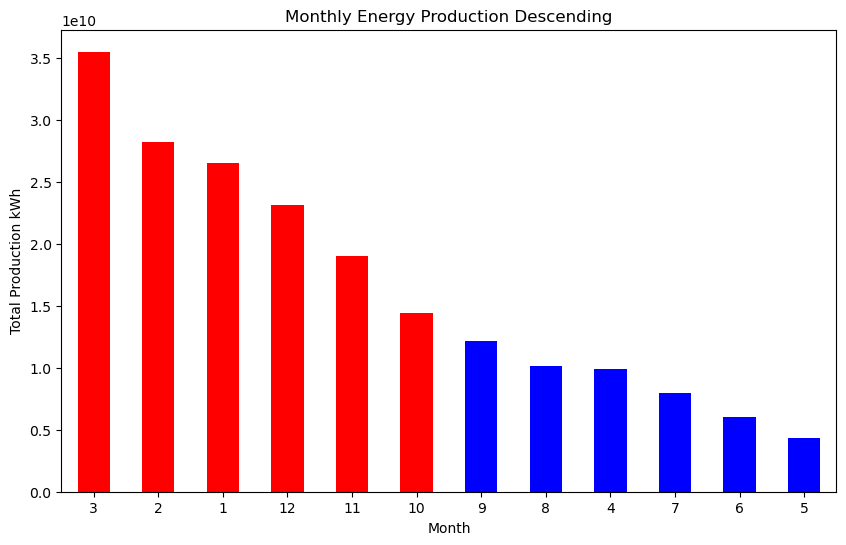

High demand months (Oct-Mar): [3, 2, 1, 12, 11, 10]
Low demand months (Apr-Sep): [9, 8, 4, 7, 6, 5]


In [5]:
# Extract the Months from SCADA data
df_scada['Month'] = df_scada['DateTime'].dt.month

# Calculate total production per month
monthly_production = df_scada.groupby('Month')['WEC: Production kWh'].sum()

# Sort months by production in descending order
sorted_monthly_production = monthly_production.sort_values(ascending=False)

# Identify top 6 high-demand months and bottom 6 low-demand months
high_demand_season = sorted_monthly_production.head(6).index.tolist()
low_demand_season = sorted_monthly_production.tail(6).index.tolist()

# Plot sorted production for visualization
plt.figure(figsize=(10, 6))
sorted_monthly_production.plot(kind='bar', color=['red' if i in high_demand_season else 'blue' for i in sorted_monthly_production.index])
plt.title('Monthly Energy Production Descending')
plt.xlabel('Month')
plt.ylabel('Total Production kWh')
plt.xticks(rotation=0)
plt.show()

# Output the identified months
print(f"High demand months (Oct-Mar): {high_demand_season}")
print(f"Low demand months (Apr-Sep): {low_demand_season}")

# Feature #2: high_season_faults and low_season_faults
This feature creates two dataframes, one for high demand season and one for low demand season, showing the fault counts for each fault type

In [6]:
df_fault['Month'] = df_fault['DateTime'].dt.month

# Tag each record with its season (High or Low demand)
df_fault['Season'] = df_fault['Month'].apply(lambda x: 'High' if x in high_demand_season else 'Low')

# Count occurrences of each fault type by season
fault_counts = df_fault.groupby(['Fault', 'Season']).size().reset_index(name='Count')

# Create separate DataFrames for high-demand and low-demand seasons
high_season_faults = fault_counts[fault_counts['Season'] == 'High']
low_season_faults = fault_counts[fault_counts['Season'] == 'Low']

print(high_season_faults)
print(low_season_faults)

  Fault Season  Count
0    AF   High      6
2    EF   High    159
4    FF   High    240
6    GF   High     37
8    MF   High      4
  Fault Season  Count
1    AF    Low     56
3    EF    Low     15
5    FF    Low     14
7    GF    Low      6
9    MF    Low     16


# Feature # 3: total_downtime_minutes, energy_loss_kwh, average_production_rate, and revenue_loss

In [7]:
# Calculate time differences between rows in 'DateTime' column and convert to minutes
df_scada['Time_Diff_Minutes'] = df_scada['DateTime'].diff().dt.total_seconds() / 60 

# Calculate the difference in production between consecutive rows
df_scada['Production Increment (kWh)'] = df_scada['WEC: Production kWh'].diff()

# Normalize production by time intervals
df_scada['Production Rate (kWh/min)'] = df_scada['Production Increment (kWh)'] / df_scada['Time_Diff_Minutes']

# Filter out invalid rows (Time_Diff_Minutes <= 0 or null, Production Increment null)
df_scada = df_scada[
    (df_scada['Time_Diff_Minutes'] > 0) & 
    (df_scada['Production Increment (kWh)'].notnull())
]

# Identify downtime rows where (Production minutes = 0)
downtime_rows = df_scada[df_scada['WEC: Production minutes'] == 0]

# Sum up the total downtime minutes
total_downtime_minutes = downtime_rows['Time_Diff_Minutes'].sum()

# Calculate the average production rate (kWh/min) for non-downtime rows
non_downtime_rows = df_scada[df_scada['WEC: Production minutes'] > 0]
average_production_rate = non_downtime_rows['Production Rate (kWh/min)'].mean()

# Calculate energy production loss during downtime
energy_loss_kwh = total_downtime_minutes * average_production_rate

# Define energy price per kWh
energy_price_per_kwh = 0.26  # Average cost of wind turbine kWh, based on research
revenue_loss = energy_loss_kwh * energy_price_per_kwh

# Output the results
print(f"Total downtime (minutes): {total_downtime_minutes:,.2f}")
print(f"Average production rate (kWh/min): {average_production_rate:,.2f}")
print(f"Energy production loss (kWh): {energy_loss_kwh:,.2f}")
print(f"Revenue loss ($): {revenue_loss:,.2f}")

Total downtime (minutes): 11,796.00
Average production rate (kWh/min): 179.32
Energy production loss (kWh): 2,115,278.26
Revenue loss ($): 549,972.35


# Feature # 4: Fault Severity

In [9]:
# Count occurrences of each combined status
status_counts = df_status['Full Status'].value_counts()

# Extract the top 9 Full Status combinations from status_counts
full_status_list = status_counts.index.tolist()

# Filter rows in df_status matching these Full Status combinations
filtered_faults = df_status[df_status['Full Status'].isin(full_status_list)]

# Display FaultMsg and Status Text for these combinations
print("Fault Messages for Top 9 Full Status Combinations:")
print(filtered_faults[['Full Status', 'FaultMsg', 'Status Text']].drop_duplicates())

Fault Messages for Top 9 Full Status Combinations:
     Full Status  FaultMsg                                        Status Text
0          0 : 0     False                               Turbine in operation
1       71 : 104      True  Insulation monitoring : Insulation fault Phase U2
2          8 : 0     False                                        Maintenance
5        240 : 1     False                   Remote control PC : switched off
6        240 : 0     False                    Remote control PC : switched on
...          ...       ...                                                ...
1526      31 : 1     False        Tower oscillation : Transversal oscillation
1530      3 : 12     False                Storm : Average windspeed - (10min)
1674    22 : 226     False  Yaw control fault : TWK NOCN: fault in cam swi...
1765       2 : 2     False                   Lack of wind : Wind speed to low
1769     66 : 32     False    Feeding fault : External shut down several inv.

[61 rows x 3

Combined Frequency, Status Text, and Severity:
   Full Status  Frequency                                        Status Text  \
0        0 : 1        393                                   Turbine starting   
1        0 : 0        365                               Turbine in operation   
2        0 : 2        331                                Turbine operational   
3        2 : 1        166                   Lack of wind : Wind speed to low   
4      80 : 21         84             Excitation error : Overvoltage DC-link   
5        0 : 8         79            Turbine in operation during maintenance   
6        0 : 5         68                       Calibration of  load control   
7        8 : 0         64                                        Maintenance   
8       62 : 3         47                      Feeding fault : Load shedding   
9     62 : 701         28        Feeding fault : Overload chopper inverter 1   
10     222 : 3         23                       Turbine reset : Scada sys

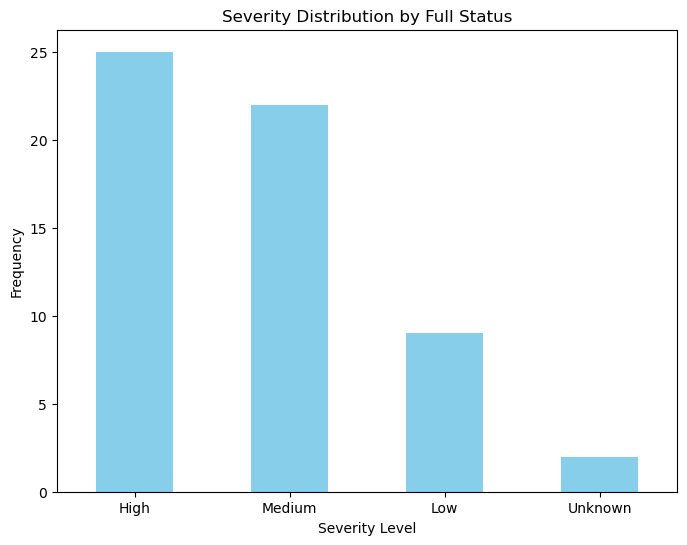

In [10]:
# Step 1: Calculate the frequency of Full Status codes
status_counts = df_status['Full Status'].value_counts().reset_index()
status_counts.columns = ['Full Status', 'Frequency']

# Step 2: Define lists of Full Status codes by severity
low_severity_codes = ['0 : 0', '8 : 0', '0 : 1', '0 : 8', '2 : 1', '0 : 2', '0 : 3', '17 : 0', '2 : 2']
medium_severity_codes = [
    '240 : 1', '9 : 3', '0 : 5', '60 : 11', '222 : 1', '60 : 2', '26 : 373', 
    '1 : 1', '21 : 2', '222 : 3', '1 : 3', '222 : 5', '60 : 12', '9 : 4', 
    '15 : 111', '15 : 19', '21 : 1', '240 : 246', '9 : 1', '31 : 1', '3 : 12', 
    '22 : 226'
]
high_severity_codes = [
    '71 : 104', '67 : 604', '220 : 56', '220 : 33', '62 : 505', '228 : 100', 
    '62 : 501', '206 : 411', '220 : 52', '220 : 51', '62 : 3', '80 : 21', 
    '42 : 307', '62 : 701', '72 : 301', '62 : 519', '62 : 510', '62 : 919', 
    '62 : 910', '62 : 502', '204 : 0', '301 : 81', '304 : 56', '307 : 14', '66 : 32'
]

# Step 3: Define a function to determine fault severity based on Full Status
def determine_severity(full_status):
    if full_status in low_severity_codes:
        return 'Low'
    elif full_status in medium_severity_codes:
        return 'Medium'
    elif full_status in high_severity_codes:
        return 'High'
    else:
        return 'Unknown'

# Step 4: Apply the severity mapping function to the DataFrame
df_status['Severity'] = df_status['Full Status'].apply(determine_severity)

# Step 5: Extract unique Full Status, Status Text, and Severity
filtered_faults = df_status[['Full Status', 'Status Text', 'Severity']].drop_duplicates()

# Step 6: Merge frequency counts with severity and status text
combined_data = pd.merge(status_counts, filtered_faults, on='Full Status', how='left')

# Step 7: Display the combined DataFrame
print("Combined Frequency, Status Text, and Severity:")
print(combined_data)

# Step 8: Optional - Analyze severity distribution
severity_counts = combined_data['Severity'].value_counts()

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
severity_counts.plot(kind='bar', color='skyblue')
plt.title('Severity Distribution by Full Status')
plt.xlabel('Severity Level')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()

# Feature # 5: Temperature features

In [74]:
# Inspect column names for temperature-related data
temperature_columns = [col for col in df_scada.columns if 'temp' in col.lower()]

# Create a DataFrame with indexed temperature columns
temperature_df = pd.DataFrame(temperature_columns, columns=["Temperature Column"])
# Display the indexed DataFrame
print("Identified Temperature Columns:")
print(temperature_df.head(10))

Identified Temperature Columns:
               Temperature Column
0  Sys 1 inverter 1 cabinet temp.
1  Sys 1 inverter 2 cabinet temp.
2  Sys 1 inverter 3 cabinet temp.
3  Sys 1 inverter 4 cabinet temp.
4  Sys 1 inverter 5 cabinet temp.
5  Sys 1 inverter 6 cabinet temp.
6  Sys 1 inverter 7 cabinet temp.
7  Sys 2 inverter 1 cabinet temp.
8  Sys 2 inverter 2 cabinet temp.
9  Sys 2 inverter 3 cabinet temp.


In [ ]:
# Step 1: Filter out blade-related columns
excluded_keywords = ['Blade', 'blade']  # Keywords for exclusion
filtered_temperature_columns = [
    col for col in temperature_columns if not any(keyword in col.lower() for keyword in excluded_keywords)
]

# Step 2: Convert temperature columns to numeric and calculate significant changes
temperature_changes_summary = {}

for col in filtered_temperature_columns:
    # Convert to numeric (if needed)
    temp_data = pd.to_numeric(df_scada[col], errors='coerce')

    # Calculate first-order differences
    temp_changes = temp_data.diff()

    # Calculate thresholds (mean ± 3*std)
    mean = temp_data.mean()
    std = temp_data.std()
    lower_threshold = mean - 5 * std
    upper_threshold = mean + 5 * std

    # Identify significant changes
    significant_changes = ((temp_changes < lower_threshold) | (temp_changes > upper_threshold)).sum()

    # Store results in a dictionary
    temperature_changes_summary[col] = {
        "Mean": mean,
        "Std": std,
        "Lower Threshold": lower_threshold,
        "Upper Threshold": upper_threshold,
        "Significant Changes": significant_changes
    }

# Step 3: Create a summary DataFrame for results
summary_df = pd.DataFrame.from_dict(temperature_changes_summary, orient='index')

# Display the summary
print(summary_df)

In [79]:
# Filter columns with Significant Changes > 40,000
filtered_summary = summary_df[summary_df['Significant Changes'] > 40000]

# Create a new DataFrame with just the column name and significant changes value
filtered_significant_changes = filtered_summary[['Significant Changes']].reset_index()
filtered_significant_changes.rename(columns={'index': 'Column Name'}, inplace=True)

# Display the filtered DataFrame
print("Filtered Columns with Significant Changes > 40,000:")
print(filtered_significant_changes)

Filtered Columns with Significant Changes > 40,000:
                      Column Name  Significant Changes
0  Sys 2 inverter 1 cabinet temp.                43543
1  Sys 2 inverter 2 cabinet temp.                42881
2  Sys 2 inverter 5 cabinet temp.                49007
3  Sys 2 inverter 7 cabinet temp.                49007
4              Rear bearing temp.                45678
5         Rectifier cabinet temp.                48930
6      Fan inverter cabinet temp.                48974
